In [4]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from collections import defaultdict

from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

from sklearn.datasets import make_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle

from sklearn.metrics import roc_curve, auc, roc_auc_score
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve

from sklearn.neighbors import KNeighborsClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn import datasets
from IPython.display import Image  
from sklearn import tree
import pydotplus

from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

In [5]:
df = pd.read_csv(r'/Users/Cava/Desktop/University/Data Science & Business Informatics/Data Mining/Advanced Topics and Applications/Project/data/training.csv')

#after uploading training and test sets, we apply some transformations: 
#date divided into date and time
#delete HumidityRatio
#remove Light outliers

df['date'] =  pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')
df['Time']= df['date'].apply(lambda x:x.time())
df['Date']= df['date'].apply(lambda x:x.date())
df['Time'] =  pd.to_timedelta(str(x) for x in df['Time'])
df['Date'] =  pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.drop('date', axis=1, inplace=True)
df.drop('Unnamed: 0',  axis=1,inplace=True)
df.drop('HumidityRatio', axis=1,inplace=True)
df=df[df['Light']<1000] 

In [6]:
test=pd.read_csv(r'/Users/Cava/Desktop/University/Data Science & Business Informatics/Data Mining/Advanced Topics and Applications/Project/data/test.csv')

test['date'] =  pd.to_datetime(test['date'], format='%Y-%m-%d %H:%M:%S')
test['Time']= test['date'].apply(lambda x:x.time())
test['Date']= test['date'].apply(lambda x:x.date())
test['Time'] =  pd.to_timedelta(str(x) for x in test['Time'])
test['Date'] =  pd.to_datetime(test['Date'], format='%Y-%m-%d')
test.drop('date', axis=1, inplace=True)
test.drop('Unnamed: 0',  axis=1,inplace=True)
test.drop('HumidityRatio',inplace=True,axis=1)

In [7]:
attributes = ['Temperature','CO2','Light','Humidity'] 

X_train =df[attributes].values
y_train=df['Occupancy'].values
X_test=test[attributes].values
y_test=test['Occupancy'].values

attributes

['Temperature', 'CO2', 'Light', 'Humidity']

# NAÏVE BAYES

### GAUSSIANO SENZA TEMPO

Dato che il tempo non è ben calcolabile dalla gaussiana decido di non utilizzarlo.\
Infatti non è considerabile come un attributo continuo, ma è meglio considerarlo come categorico.

La fuzione gaussiana facendo la differenza tra due orari della giornata non andrebbe a considere la ciclicità del tempo.

In [8]:
clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred0=y_pred
y_score=clf.predict_proba(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9656290531776913
F1-score [0.97716993 0.9304918 ]
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      4747
           1       0.87      1.00      0.93      1421

    accuracy                           0.97      6168
   macro avg       0.94      0.98      0.95      6168
weighted avg       0.97      0.97      0.97      6168



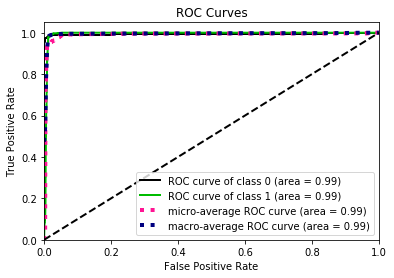

In [9]:
plot_roc(y_test, y_score)
plt.show()

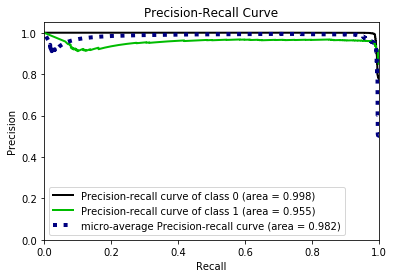

In [10]:
plot_precision_recall(y_test, y_score)
plt.show()

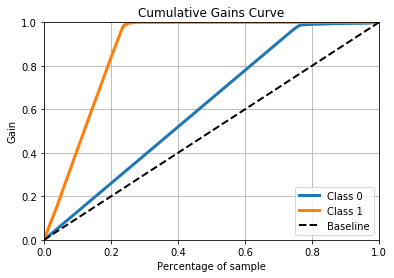

In [11]:
plot_cumulative_gain(y_test, y_score)
plt.show()

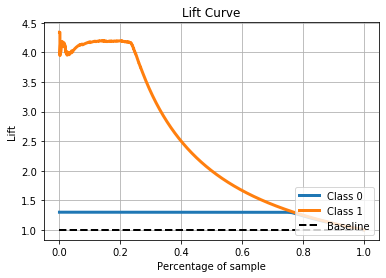

In [12]:
plot_lift_curve(y_test, y_score)
plt.show()

### CATEGORICA    (solo tempo)

utilizzo solo date e time per questa classificazione , considerandoli gli unici due attributi categorici

di Time mantengo solo Hour per evitare overfitting 

tenendo conto che appare dalle analisi precendemnte fatte, per evitare ridondanza estraggo dalla data il giorno della settimana e controllo se è festivo, l' attributo <b>Holidays</b> assume così il valore 1 se il giorno è festivo

In [16]:
df['Time']

0       04:01:00
1       21:49:00
2       23:19:00
3       17:36:00
4       11:16:00
          ...   
14386   00:30:59
14387   09:16:59
14388   04:51:00
14389   17:55:00
14390   23:06:00
Name: Time, Length: 14384, dtype: timedelta64[ns]

In [14]:
df['Hour']= df['Time'].apply(lambda x:str(x)[7:9]+str(x)[10])
#df['Date']= df['Date'].apply(lambda x:str(x)[8:10])

test['Hour']= test['Time'].apply(lambda x: str(x)[7:9]+str(x)[10])
#test['Date']= test['Date'].apply(lambda x:str(x)[8:10])

In [15]:
df['Hour']

0        040
1        214
2        231
3        173
4        111
        ... 
14386    003
14387    091
14388    045
14389    175
14390    230
Name: Hour, Length: 14384, dtype: object

In [11]:
df['Holidays'] = df['Date'].apply(lambda x: 0 if x.weekday()<5 else 1 )
test['Holidays'] = test['Date'].apply(lambda x: 0 if x.weekday()<5 else 1 )

In [12]:
df['Holidays']=df['Holidays'].astype(str)
test['Holidays']=test['Holidays'].astype(str)
df['Hour']=df['Hour'].astype(str)
test['Hour']=test['Hour'].astype(str)

In [13]:
print(df[['Hour','Holidays']],df.dtypes)

      Hour Holidays
0      040        0
1      214        1
2      231        0
3      173        0
4      111        0
...    ...      ...
14386  003        0
14387  091        0
14388  045        0
14389  175        0
14390  230        0

[14384 rows x 2 columns] Temperature            float64
Humidity               float64
Light                  float64
CO2                    float64
Occupancy                int64
Time           timedelta64[ns]
Date            datetime64[ns]
Hour                    object
Holidays                object
dtype: object


In [14]:
rdf=df[['Hour','Holidays']].copy()
rtest=test[['Hour','Holidays']].copy()

r=rdf.append(rtest)

In [15]:
X_train_cat=rdf.values
X_test_cat=rtest.values
y_train=df['Occupancy'].values
y_test=test['Occupancy'].values

attributes = ['Temperature','CO2','Light','Humidity'] 



    
X_train_cat =df[attributes].values
y_train=df['Occupancy'].values
X_test_cat=test[attributes].values
y_test=test['Occupancy'].values

In [16]:
clf = CategoricalNB()
clf.fit(X_train_cat, y_train)

CategoricalNB(alpha=1.0, class_prior=None, fit_prior=True)

In [17]:
y_pred = clf.predict(X_test_cat)
y_pred1 =y_pred
y_score=clf.predict_proba(X_test_cat)

In [18]:
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

#A quanto pare data e tmepo da soli sono sufficienti per avere già una buona classificazione

Accuracy 0.9567120622568094
F1-score [0.97176097 0.90732385]
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      4747
           1       0.90      0.92      0.91      1421

    accuracy                           0.96      6168
   macro avg       0.94      0.94      0.94      6168
weighted avg       0.96      0.96      0.96      6168



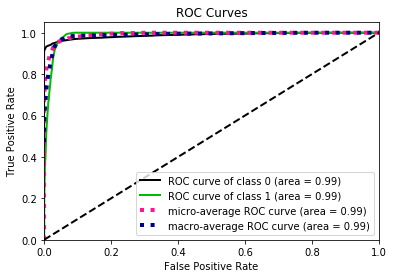

In [19]:
plot_roc(y_test, y_score)
plt.show()

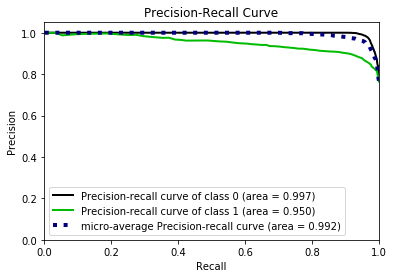

In [20]:
plot_precision_recall(y_test, y_score)
plt.show()

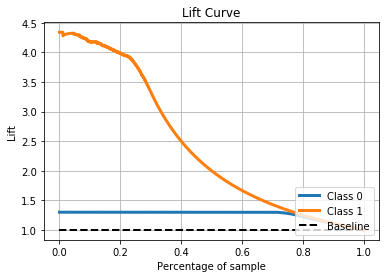

In [21]:
plot_lift_curve(y_test, y_score)
plt.show()

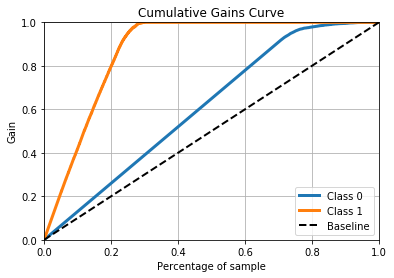

In [22]:
plot_cumulative_gain(y_test, y_score)
plt.show()

### comparison

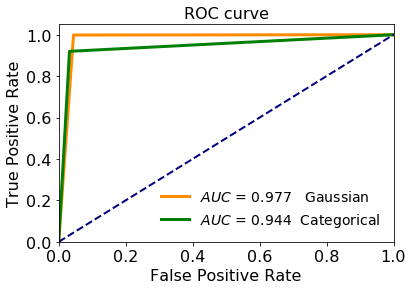

In [23]:
fpr0, tpr0, _ = roc_curve(y_test, y_pred0)
roc_auc0 = auc(fpr0, tpr0)

fpr1, tpr1, _ = roc_curve(y_test, y_pred1)
roc_auc1 = auc(fpr1, tpr1)


plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC$ = %.3f   Gaussian' % (roc_auc0))
plt.plot(fpr1, tpr1, color='green', lw=3, label='$AUC$ = %.3f  Categorical' % (roc_auc1))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()



In [24]:
df

,Temperature,Humidity,Light,CO2,Occupancy,Time,Date,Hour,Holidays
0,20.70,24.8400,0.00,587.50,0,04:01:00,2015-02-12,040,0
1,19.79,35.2000,0.00,524.50,0,21:49:00,2015-02-14,214,1
2,20.89,25.2000,0.00,557.20,0,23:19:00,2015-02-03,231,0
3,22.20,24.3340,429.50,913.00,1,17:36:00,2015-02-05,173,0
4,22.08,28.3700,544.20,1198.60,1,11:16:00,2015-02-03,111,0
...,...,...,...,...,...,...,...,...,...
14386,20.60,26.8900,0.00,508.00,0,00:30:59,2015-02-12,003,0
14387,21.20,25.3925,454.75,782.00,1,09:16:59,2015-02-03,091,0
14388,19.29,26.8900,0.00,465.50,0,04:51:00,2015-02-09,045,0
14389,21.70,20.8900,433.00,802.25,1,17:55:00,2015-02-06,175,0


### BERNOULLI NB

Bernolli classifica utilizzando solo variabili binarie, tuttavia è possibile passargli anche float o categorci con piu di due valori possibili che verranno binarizzati

In [25]:
attributes = ['Temperature','CO2','Light','Humidity','Hour','Holidays'] 
X_train_B = df[attributes].copy()
X_test_B = test[attributes].copy()

In [26]:
X_train_B

,Temperature,CO2,Light,Humidity,Hour,Holidays
0,20.70,587.50,0.00,24.8400,040,0
1,19.79,524.50,0.00,35.2000,214,1
2,20.89,557.20,0.00,25.2000,231,0
3,22.20,913.00,429.50,24.3340,173,0
4,22.08,1198.60,544.20,28.3700,111,0
...,...,...,...,...,...,...
14386,20.60,508.00,0.00,26.8900,003,0
14387,21.20,782.00,454.75,25.3925,091,0
14388,19.29,465.50,0.00,26.8900,045,0
14389,21.70,802.25,433.00,20.8900,175,0


In [27]:
f=lambda x: str(x)[0]
for col in attributes[:4]:
    X_train_B[col]= [f(x) for x in X_train_B[col]]
    X_test_B[col] = [f(x) for x in X_test_B[col] ]

In [28]:
X_train_B=X_train_B.values
X_test_B=X_test_B.values

In [29]:
X_train_B

array([['2', '5', '0', '2', '040', '0'],
       ['1', '5', '0', '3', '214', '1'],
       ['2', '5', '0', '2', '231', '0'],
       ...,
       ['1', '4', '0', '2', '045', '0'],
       ['2', '8', '4', '2', '175', '0'],
       ['2', '5', '0', '3', '230', '0']], dtype=object)

In [30]:
attributes = ['Temperature','CO2','Light','Humidity','Hour','Holidays'] 
X_train_B = df[attributes]


    
X_train_B =df[attributes].values
y_train=df['Occupancy'].values
X_test_B=test[attributes].values
y_test=test['Occupancy'].values

In [31]:
from sklearn.naive_bayes import BernoulliNB

clf = BernoulliNB()
clf.fit(X_train_B, y_train)

y_pred = clf.predict(X_test_B)
y_pred2 =y_pred
y_score=clf.predict_proba(X_test_B)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))


Accuracy 0.9620622568093385
F1-score [0.97473002 0.92392718]
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      4747
           1       0.86      1.00      0.92      1421

    accuracy                           0.96      6168
   macro avg       0.93      0.98      0.95      6168
weighted avg       0.97      0.96      0.96      6168



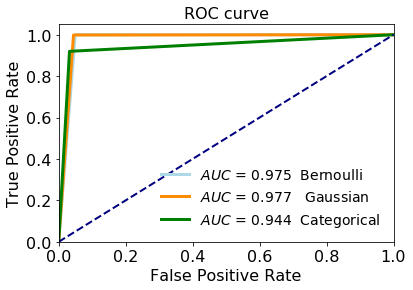

In [32]:
fpr0, tpr0, _ = roc_curve(y_test, y_pred0)
roc_auc0 = auc(fpr0, tpr0)

fpr1, tpr1, _ = roc_curve(y_test, y_pred1)
roc_auc1 = auc(fpr1, tpr1)

fpr2, tpr2, _ = roc_curve(y_test, y_pred2)
roc_auc2 = auc(fpr2, tpr2)


plt.plot(fpr2, tpr2, color='lightblue', lw=3, label='$AUC$ = %.3f  Bernoulli' % (roc_auc2))
plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC$ = %.3f   Gaussian' % (roc_auc0))
plt.plot(fpr1, tpr1, color='green', lw=3, label='$AUC$ = %.3f  Categorical' % (roc_auc1))


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()



### MULTINOMIAL NB

In [33]:
attributes = ['Temperature','CO2','Light','Humidity','Hour','Holidays'] 
 
X_train_cat =df[attributes].values
y_train=df['Occupancy'].values
X_test_cat=test[attributes].values
y_test=test['Occupancy'].values

In [34]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
clf.fit(X_train_cat, y_train)

y_pred = clf.predict(X_test_cat)
y_pred1 =y_pred
y_score=clf.predict_proba(X_test_cat)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.940337224383917
F1-score [0.95967565 0.88535826]
              precision    recall  f1-score   support

           0       1.00      0.92      0.96      4747
           1       0.79      1.00      0.89      1421

    accuracy                           0.94      6168
   macro avg       0.90      0.96      0.92      6168
weighted avg       0.95      0.94      0.94      6168



In [35]:
X_train_cat.shape

(14384, 6)

# KNN
### optimal K?

In [36]:
# Creating odd list K for KNN
neighbors = list(range(1,25,2))
# empty list that will hold cv scores
cv_scores = [ ]
#perform 10-fold cross-validation
for K in neighbors:
    knn = KNeighborsClassifier(n_neighbors = K)
    scores = cross_val_score(knn,X_train,y_train,cv = 10,scoring =
    "accuracy")
    cv_scores.append(scores.mean())

In [37]:
# Changing to mis classification error
mse = [1-x for x in cv_scores]
# determing best k
optimal_k = neighbors[mse.index(min(mse))]
print("The optimal no. of neighbors is {}".format(optimal_k))

The optimal no. of neighbors is 13


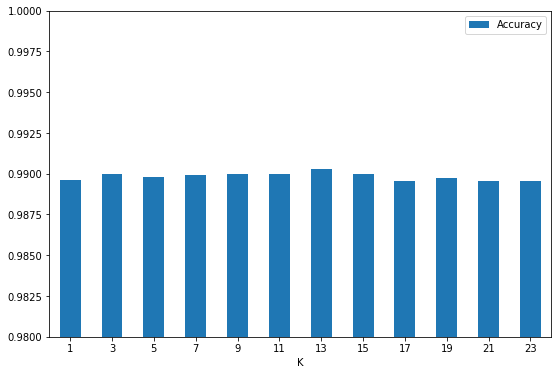

In [38]:
import matplotlib.pyplot as plt
def plot_accuracy(knn_list_scores):
    pd.DataFrame({"K":[i for i in range(1,25,2)], "Accuracy":knn_list_scores}).set_index("K").plot.bar(figsize= (9,6),ylim=(0.98,1),rot=0)
    plt.show()
plot_accuracy(cv_scores)

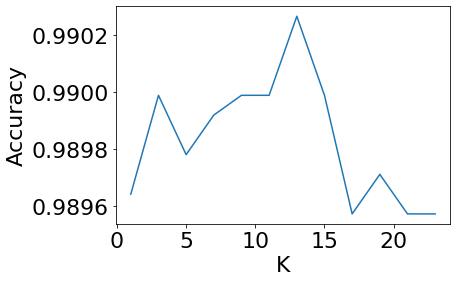

In [39]:
plt.plot(range(1,25,2), cv_scores)
plt.ylabel('Accuracy', fontsize=22)
plt.xlabel('K', fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

### classification

In [40]:
clf = KNeighborsClassifier(n_neighbors=13, weights='uniform')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9904345006485085
F1-score [0.99375727 0.97954939]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4747
           1       0.97      0.99      0.98      1421

    accuracy                           0.99      6168
   macro avg       0.98      0.99      0.99      6168
weighted avg       0.99      0.99      0.99      6168



In [41]:
clf = KNeighborsClassifier(n_neighbors=13, weights='distance')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9964332036316472
F1-score [0.99767981 0.99229152]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4747
           1       0.99      1.00      0.99      1421

    accuracy                           1.00      6168
   macro avg       0.99      1.00      0.99      6168
weighted avg       1.00      1.00      1.00      6168



In [42]:
clf = KNeighborsClassifier(n_neighbors=13, weights='distance', algorithm='ball_tree')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9964332036316472
F1-score [0.99767981 0.99229152]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4747
           1       0.99      1.00      0.99      1421

    accuracy                           1.00      6168
   macro avg       0.99      1.00      0.99      6168
weighted avg       1.00      1.00      1.00      6168



### CROSS-VALIDATION 

In [43]:
scores = cross_val_score(clf, X_train, y_train, cv=10)
print('Accuracy: %0.4f (+/- %0.3f)' % (scores.mean(), scores.std()))

scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='f1_macro')
print('F1-score: %0.4f (+/- %0.3f)' % (scores.mean(), scores.std()))

Accuracy: 0.9901 (+/- 0.002)
F1-score: 0.9863 (+/- 0.003)


### GridSearch

In [44]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV

In [45]:
parameters = {'n_neighbors': np.arange(1, 25,2), 'weights':['uniform', 'distance']}

knn = KNeighborsClassifier()
search = GridSearchCV(knn, parameters)
search.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23]),
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [46]:
clf = search.best_estimator_

y_score=clf.predict_proba(X_test)

y_pred = clf.predict(X_test)
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9965953307392996
F1-score [0.99778598 0.99263416]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4747
           1       0.99      1.00      0.99      1421

    accuracy                           1.00      6168
   macro avg       0.99      1.00      1.00      6168
weighted avg       1.00      1.00      1.00      6168



In [47]:
search.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='distance')

### EVALUATION

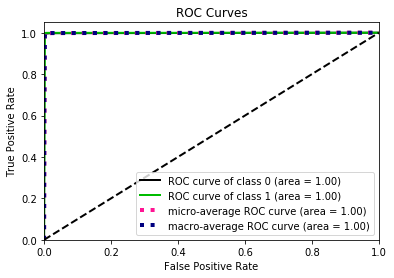

In [48]:
plot_roc(y_test, y_score)
plt.show()

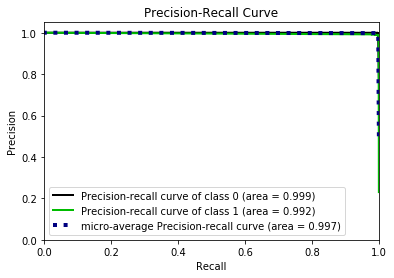

In [49]:
plot_precision_recall(y_test, y_score)
plt.show()

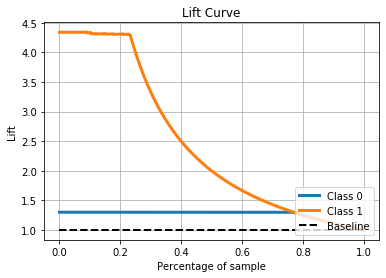

In [50]:
plot_lift_curve(y_test, y_score)
plt.show()

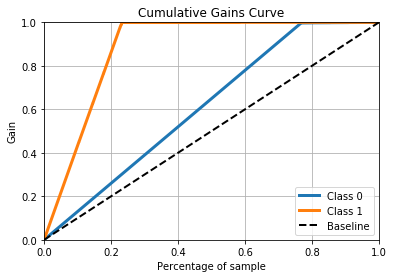

In [51]:
plot_cumulative_gain(y_test, y_score)
plt.show()

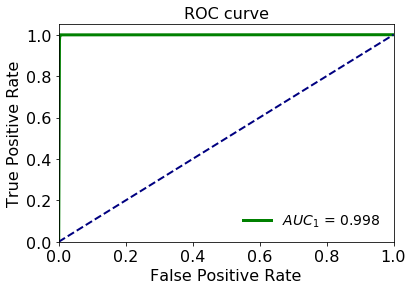

In [52]:
fpr, tpr, thr = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

# Decision Tree

In [53]:
df['Hour']= df['Time'].apply(lambda x:'H'+ str(x)[7:9])
#df['Date']= df['Date'].apply(lambda x:str(x)[8:10])

test['Hour']= test['Time'].apply(lambda x:'H'+ str(x)[7:9])
#test['Date']= test['Date'].apply(lambda x:str(x)[8:10])

In [54]:
df_enc=df.copy()
test_enc=test.copy()

df_enc = pd.get_dummies( df_enc, columns = ['Hour'])
test_enc = pd.get_dummies( test_enc, columns = ['Hour'])

df_enc.drop('Time',axis=1,inplace=True)
df_enc.drop('Date',axis=1,inplace=True)
test_enc.drop('Time',axis=1,inplace=True)
test_enc.drop('Date',axis=1,inplace=True)

In [55]:
df_enc

,Temperature,Humidity,Light,CO2,Occupancy,Holidays,Hour_H00,Hour_H01,Hour_H02,Hour_H03,...,Hour_H14,Hour_H15,Hour_H16,Hour_H17,Hour_H18,Hour_H19,Hour_H20,Hour_H21,Hour_H22,Hour_H23
0,20.70,24.8400,0.00,587.50,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,19.79,35.2000,0.00,524.50,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,20.89,25.2000,0.00,557.20,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,22.20,24.3340,429.50,913.00,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,22.08,28.3700,544.20,1198.60,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14386,20.60,26.8900,0.00,508.00,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14387,21.20,25.3925,454.75,782.00,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14388,19.29,26.8900,0.00,465.50,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14389,21.70,20.8900,433.00,802.25,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [56]:
for col in df_enc.columns[1:]:
    if col not in test_enc.columns[1:]:
        test_enc[col]=0
for col in test_enc.columns[1:]:
    if col not in df_enc.columns[1:]:
        df_enc[col]=0

In [73]:
attributes = [col for col in df_enc.columns if col != 'Occupancy']

X_train =df_enc[attributes].values
y_train=df_enc['Occupancy'].values
X_test=test_enc[attributes].values
y_test=test_enc['Occupancy'].values

In [79]:
clf = DecisionTreeClassifier(min_samples_leaf=3, max_depth=7, random_state=42)
clf.fit(X_train, y_train)

y_pred0 = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred0))
print('F1-score %s' % f1_score(y_test, y_pred0, average=None))
print(classification_report(y_test, y_pred0))

Accuracy 0.9914072632944229
F1-score [0.99440042 0.98153953]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4747
           1       0.97      0.99      0.98      1421

    accuracy                           0.99      6168
   macro avg       0.98      0.99      0.99      6168
weighted avg       0.99      0.99      0.99      6168



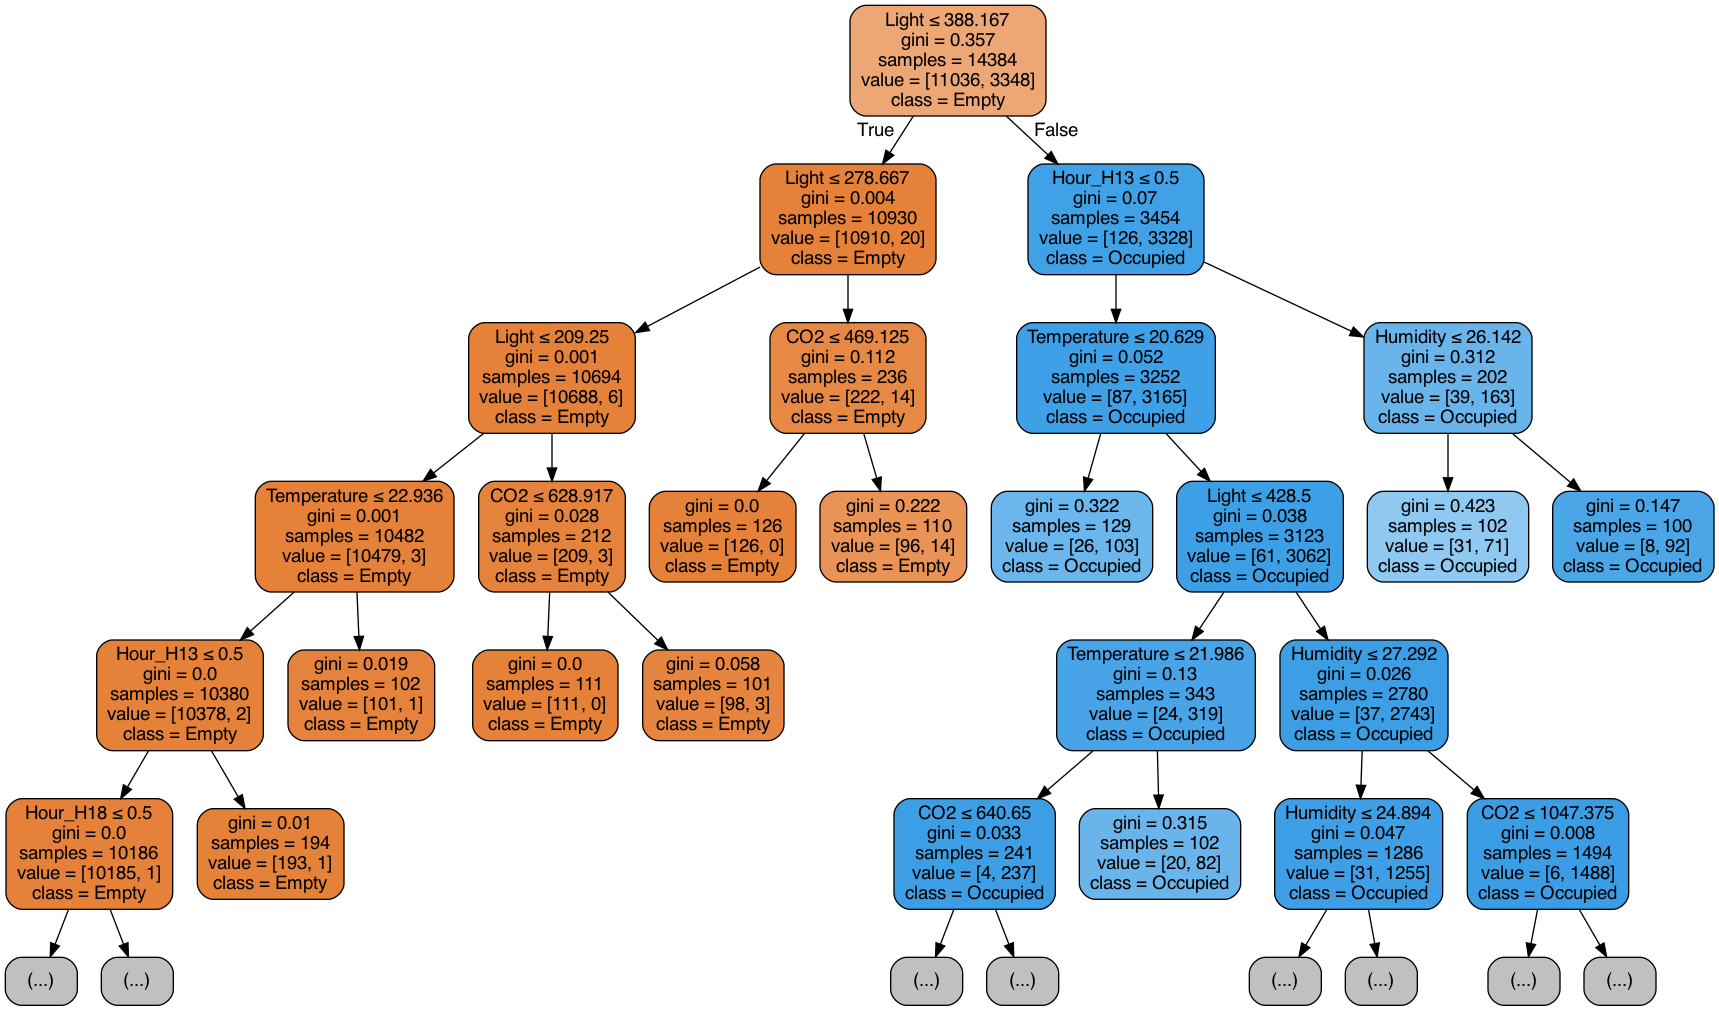

In [59]:
dot_data = tree.export_graphviz(clf, out_file=None,  
                                feature_names=attributes, 
                                class_names=['Empty','Occupied'],  
                                filled=True, rounded=True,  
                                special_characters=True,
                                max_depth=5)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [60]:
clf = DecisionTreeClassifier(min_samples_leaf=100, max_depth=5, random_state=42)
clf.fit(X_train, y_train)

y_pred0 = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred0))
print('F1-score %s' % f1_score(y_test, y_pred0, average=None))
print(classification_report(y_test, y_pred0))

Accuracy 0.9899481193255513
F1-score [0.99343776 0.97853186]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4747
           1       0.96      0.99      0.98      1421

    accuracy                           0.99      6168
   macro avg       0.98      0.99      0.99      6168
weighted avg       0.99      0.99      0.99      6168



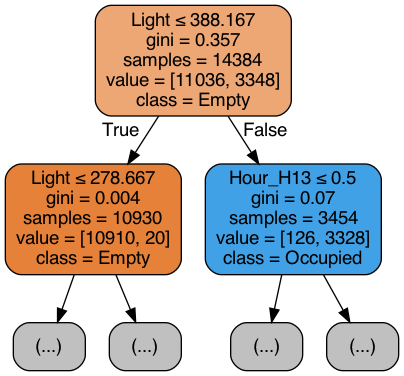

In [61]:
dot_data = tree.export_graphviz(clf, out_file=None,  
                                feature_names=attributes, 
                                class_names=['Empty','Occupied'],  
                                filled=True, rounded=True,  
                                special_characters=True,
                                max_depth=1)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [62]:
clf = DecisionTreeClassifier(min_samples_leaf=10, max_depth=1, random_state=42)
clf.fit(X_train, y_train)

y_pred0 = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred0))
print('F1-score %s' % f1_score(y_test, y_pred0, average=None))
print(classification_report(y_test, y_pred0))

Accuracy 0.9899481193255513
F1-score [0.99343776 0.97853186]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4747
           1       0.96      0.99      0.98      1421

    accuracy                           0.99      6168
   macro avg       0.98      0.99      0.99      6168
weighted avg       0.99      0.99      0.99      6168



In [81]:
(1-(0.9899481193255513/0.9914072632944229))*100

0.14717906786589907

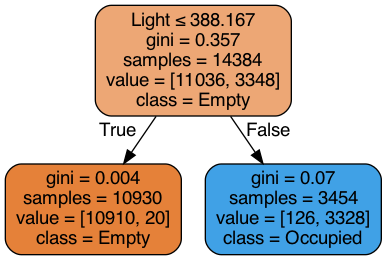

In [63]:
dot_data = tree.export_graphviz(clf, out_file=None,  
                                feature_names=attributes, 
                                class_names=['Empty','Occupied'],  
                                filled=True, rounded=True,  
                                special_characters=True,
                                max_depth=7)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [64]:
clf = DecisionTreeClassifier(min_samples_leaf=10, max_depth=7, random_state=42)
clf.fit(X_train, y_train)

y_pred0 = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred0))
print('F1-score %s' % f1_score(y_test, y_pred0, average=None))
print(classification_report(y_test, y_pred0))

Accuracy 0.9905966277561609
F1-score [0.99388057 0.97970609]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4747
           1       0.97      0.99      0.98      1421

    accuracy                           0.99      6168
   macro avg       0.98      0.99      0.99      6168
weighted avg       0.99      0.99      0.99      6168



In [65]:
X=df[['Temperature','CO2','Light','Humidity']]
XT=test[['Temperature','CO2','Light','Humidity']]

In [72]:
clf = DecisionTreeClassifier(min_samples_leaf=10, max_depth=20, random_state=42)
clf.fit(X, y_train)

y_pred1 = clf.predict(XT)

print('Accuracy %s' % accuracy_score(y_test, y_pred1))
print('F1-score %s' % f1_score(y_test, y_pred1, average=None))
print(classification_report(y_test, y_pred1))

Accuracy 0.996757457846952
F1-score [0.99789252 0.99297259]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4747
           1       0.99      0.99      0.99      1421

    accuracy                           1.00      6168
   macro avg       0.99      1.00      1.00      6168
weighted avg       1.00      1.00      1.00      6168



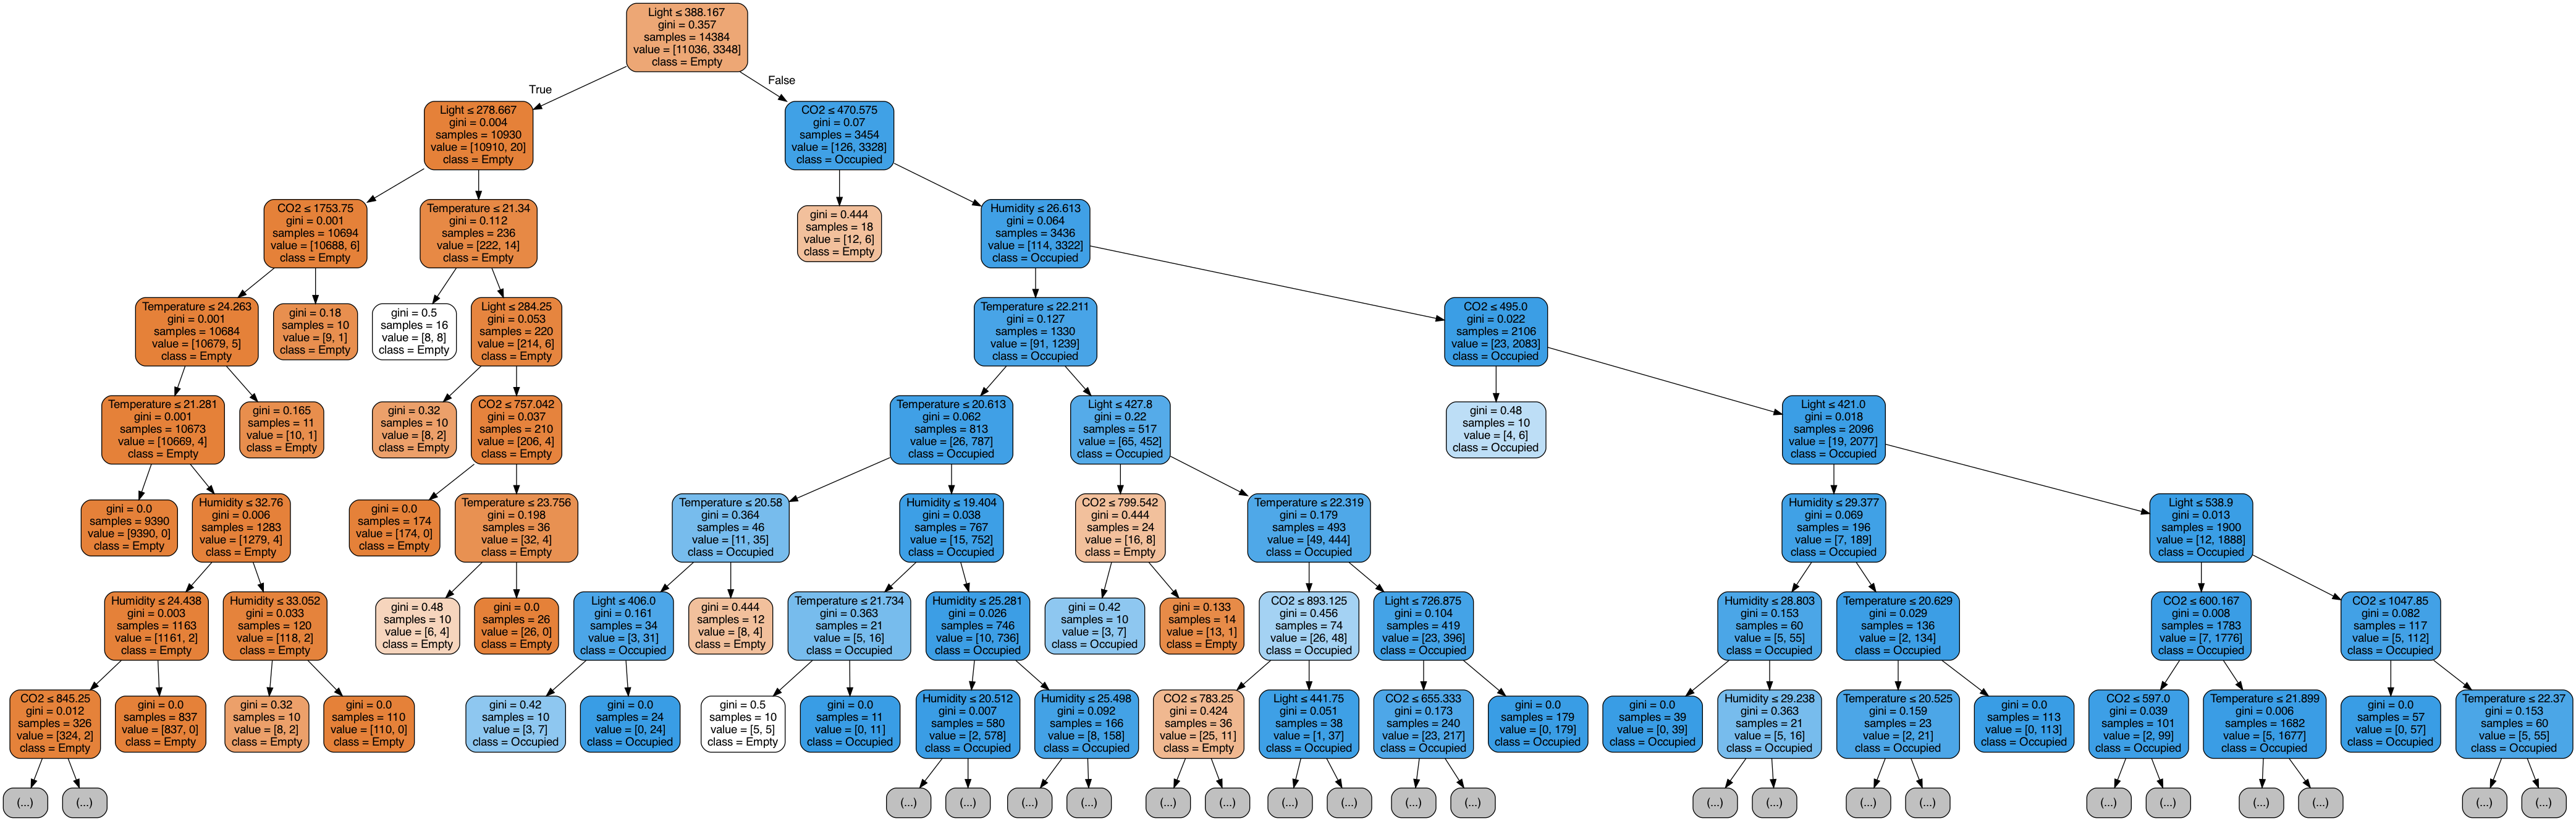

In [67]:
dot_data = tree.export_graphviz(clf, out_file=None,  
                                feature_names=['Temperature','CO2','Light','Humidity'], 
                                class_names=['Empty','Occupied'],  
                                filled=True, rounded=True,  
                                special_characters=True,
                                max_depth=7)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [68]:
df['Occupancy'].value_counts()

0    11036
1     3348
Name: Occupancy, dtype: int64